# Recommender Systems With Sentiment Analysis
<br>
This notebook contains the code for the ACW Project (Presentation and Report) for Applied AI. It look to predict the sentiment from IMDB user reviews of movies and classify a review as being either positive or negative. 

## 1) Libraries, Data and Exploration. 
The first steps are to import the libraries, read in the data and do a bit of exploration on the data to see what it is like. 

In [3]:
# Import Libraries 

import re
import nltk 
import spacy
import  matplotlib

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

from bs4 import BeautifulSoup

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

from spellchecker import SpellChecker

from IPython.display import display

In [4]:
# Read in the dataset

data = pd.read_csv("IMDB Dataset.csv")

In [5]:
# See what the data looks like 
data.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


<AxesSubplot:>

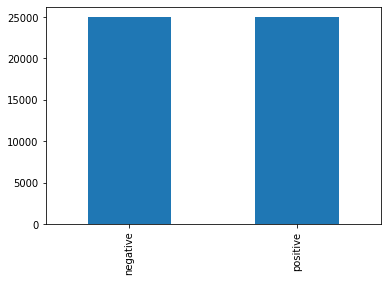

In [7]:
data.sentiment.value_counts().plot(kind = 'bar')

In [8]:
print(f'Rows: {data.shape[0]}, Columns: {data.shape[1]} in the dataset.')

Rows: 50000, Columns: 2 in the dataset.


From the basic exploration of the data above, it can be seen that there is a perfectly equal split of positive and negative reviews in the data, so we don't have to worry about offesetting the class imbalence here when we come to measure the performance of the models. 

## 2) Data Cleaning
<br>
Before we can give the data to any models we need to make sure that the data is usable, this process will take many steps, which I will describe in the comments below. 

In [9]:
# Convert the Sentiment to 1 for positive and 0 for negative
def convert_sentiment(data):
    data = re.sub('positive', '1', data)
    data = re.sub('negative', '0', data)
    return data

# Remove any hyperlinks from the text
def remove_hyperlink(data):
    isurl = re.compile(r'https?://\S+|www.\.\S+')
    return isurl.sub(r'', data)

# Remove any special characters
def remove_special_chars(data):
    data = re.sub('[,\.!:;()"]', ' ', data)
    data = re.sub('[^a-zA-Z"]', ' ', data)
    data = re.sub('\[[^]]*\]', ' ', data)
    data = re.sub("'", '', data)
    return data

# Remove any HTML
def remove_html(data):
    soup = BeautifulSoup(data, 'html.parser')
    return soup.get_text()

# Remove any Emojis
def remove_emojis(data):
    emojis = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return emojis.sub(r'',data)

# Remove double spaces
def remove_doublespaces(data):
    data = re.sub('  ', ' ', data)
    data = re.sub('  ', ' ', data)
    return data

# Make Lower Case
def make_lower(data):
    data = data.str.lower()
    return data
    
# Correct Mispellings 
spell = SpellChecker()
def correct_spelling(data):
    corrected = []
    mispellings = spell.unknown(data.split())
    for word in data.split():
        if word in mispellings:
            corrected.append(spell.correction(word))
        else:
            corrected.append(word)
    return " ".join(corrected)

# Tokenize and remove stopwords 
stopw = set(stopwords.words('english'))
def filter_on_stopwords(data):
    word_tokens = word_tokenize(data)
    no_stopword_tokens = [token for token in word_tokens if token not in stopw]
    data = ' '.join(no_stopword_tokens)
    return data

#Lemmatize the words as it worked better than stemming the words in the draft version
sp = spacy.load('en_core_web_sm')
def lemmatize_words(data):
    doc = sp(data)   
    data = ' '.join([token.lemma_ for token in doc])
    return data


In [39]:
test = 'This is a <b>string</b> for testsing and @email.com, maybe   https://there.is.a.website and how about an emoji 😊'

In [40]:
# Call functions
data['sentiment'] = data['sentiment'].apply(convert_sentiment)
data['review'] = data['review'].apply(remove_hyperlink)
data['review'] = data['review'].apply(remove_special_chars)
data['review'] = data['review'].apply(remove_html)
data['review'] = data['review'].apply(remove_emojis)
data['review'] = data['review'].apply(remove_doublespaces)
data['review'] = make_lower(data['review'])
data['review'] = data['review'].apply(correct_spelling)
data['review'] = data['review'].apply(filter_on_stopwords)
data['review'] = data['review'].apply(lemmatize_words)
# Call functions for test
test = remove_hyperlink(test)
test = remove_special_chars(test)
test = remove_html(test)
test = remove_emojis(test)
test = remove_doublespaces(test)
#make_lower(test)
test = correct_spelling(test)
test = filter_on_stopwords(test)
test = lemmatize_words(test)

print(test)

this string testing email com maybe emoji


In [11]:
clean_data = data
clean_data.to_csv('clean_imdb_data.csv')

## 3) Further Data Exploration
<br>
Now the data has been cleaned, further exploration of the data can be done to see what is happening in more detail.

Text(0.5, 1.0, 'Most Common Words in Negative Reviews')

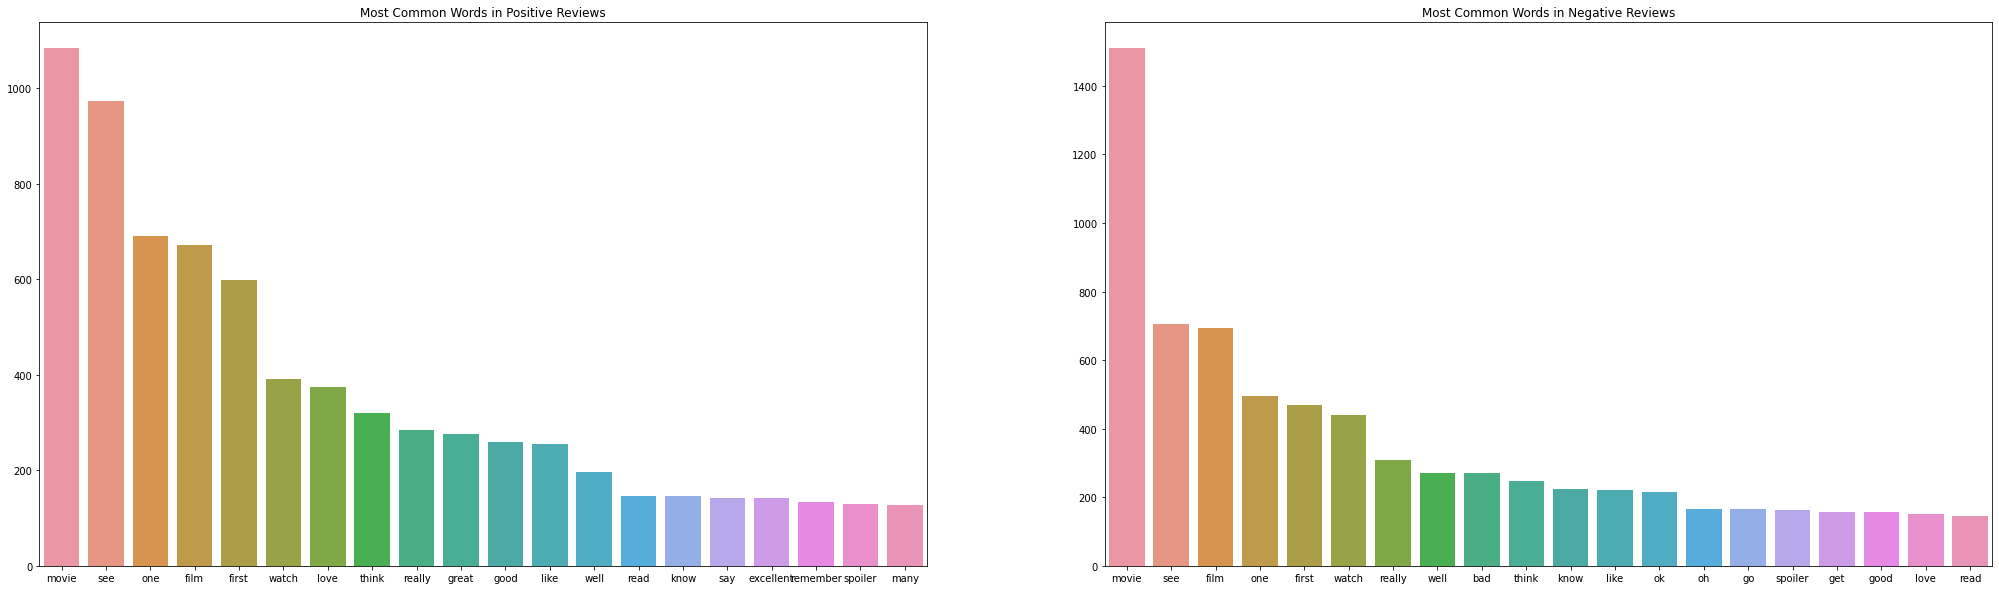

In [47]:
# Get the frequency distribution of the most popular words
words = [word for word in pd.Series(' '.join(clean_data['review']).split())]
most_used_words = FreqDist(words).most_common(20)
most_used_words = pd.Series(dict(most_used_words))
#Plot the most commonly used words
fig, (ax1, ax2,) = plt.subplots(1, 2,  figsize=(35,10))

#Get the frequency distribution where tweets are about disaster
positive_reviews = clean_data[clean_data['sentiment']=='1']['review']
positive_words = [word.split()[0] for word in positive_reviews]
most_used_positive_words = FreqDist(positive_words).most_common(20)
most_used_positive_words = pd.Series(dict(most_used_positive_words))
sns.barplot(x = most_used_positive_words.index, y = most_used_positive_words.values, ax=ax1)

negative_reviews = clean_data[clean_data['sentiment']=='0']['review']
negative_words = [word.split()[0] for word in negative_reviews]
most_used_negative_words = FreqDist(negative_words).most_common(20)
most_used_negative_words = pd.Series(dict(most_used_negative_words))
sns.barplot(x = most_used_negative_words.index, y = most_used_negative_words.values, ax=ax2)

ax1.set_title('Most Common Words in Positive Reviews')
ax2.set_title('Most Common Words in Negative Reviews')

In [13]:
# Get the number of unique words in the data
unique_words = []
for word in words:
    if not word in unique_words:
        unique_words.append(word)

print(f'Number of Uniques Words: {len(unique_words)}')

Number of Uniques Words: 58814


Text(0.5, 1.0, 'Chars in Negative Reviews')

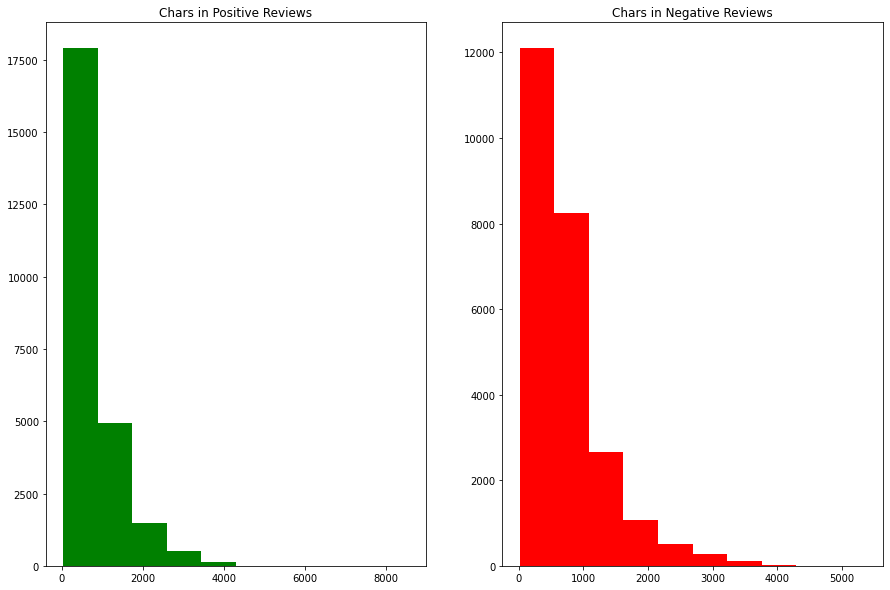

In [14]:
# Get the number of characters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
# Get len of disaster tweets
ps_review_length = clean_data[clean_data['sentiment']=='1']['review'].str.len()
ax1.hist(ps_review_length, color = 'green')
ax1.set_title('Chars in Positive Reviews')
# Get len of tweets that are not about disaster
ng_tweet_length = clean_data[clean_data['sentiment']=='0']['review'].str.len()
ax2.hist(ng_tweet_length, color = 'red')
ax2.set_title('Chars in Negative Reviews')

In [15]:
# Compile a vocabulary of words from the reviews
vocab = []
for i in words:
    if i not in vocab:
        vocab.append(i)

vocabulary = sorted(vocab)
print(vocabulary)

["'", "'d", "'ll", "'s", 'I', 'a', 'aaaaaaaaaaaahhhhhhhhhhhhhh', 'aaaaaaaargh', 'aaaaaaah', 'aaaaaaahhhhhhggg', 'aaaaagh', 'aaaaahhhh', 'aaaaargh', 'aaaaarrrrrrgggggghhhhhh', 'aaaaatch', 'aaaahhhhhh', 'aaaahhhhhhh', 'aaaarrgh', 'aaaawwwwww', 'aaaggghhhhhhh', 'aaahhhhhhh', 'aaarrrgh', 'aaawwwwnnn', 'aahhhh', 'aailiyah', 'aakrosh', 'aankhen', 'aardvark', 'aauugghh', 'ab', 'aback', 'abad', 'abanazer', 'abandon', 'abandoned', 'abandonment', 'abash', 'abashidze', 'abate', 'abatement', 'abattoir', 'abba', 'abbas', 'abbe', 'abbey', 'abbie', 'abbot', 'abbott', 'abbreviate', 'abby', 'abc', 'abcs', 'abd', 'abderrahmane', 'abdicate', 'abdo', 'abdoman', 'abdomen', 'abdominal', 'abduct', 'abducted', 'abductee', 'abducting', 'abduction', 'abductor', 'abdul', 'abdullah', 'abdulrahman', 'abe', 'abecassis', 'abedalla', 'abel', 'abemethie', 'aber', 'abercrombie', 'aberdeen', 'abernathy', 'abernethie', 'aberrant', 'aberration', 'aberystwyth', 'abet', 'abeyance', 'abhay', 'abhi', 'abhijeet', 'abhimaan', '

## 4) TF-IDF
<br>
TF-IDF is Term Frequency, Inverse Document Frequency. It is used to refect how important a word is to the overall collection of reviews. 

In [79]:
#Split data for train,test
x_train = clean_data.review[:35000]
y_train = clean_data.sentiment[:35000]
x_test = clean_data.review[35000:]
y_test = clean_data.sentiment[35000:]


It seems as though the positive reviews are slightly longer on average than negative reviews.

In [80]:
# Give the data a numerical representation using TF-IDF
# The numerical representation will signifiy the importance of the word in the dataset
tfidf = TfidfVectorizer(max_df=0.2, min_df = 0.02)
# Apply tfidf to train 
tfidf_train = tfidf.fit_transform(x_train)
tfidf_train_df = pd.DataFrame(tfidf_train.toarray(), columns = tfidf.get_feature_names())
tfidf_train_df.head()
# Apply tfidf to test 
tfidf_test = tfidf.transform(x_test)
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns = tfidf.get_feature_names())
tfidf_test_df.head()

,ability,able,absolutely,accent,accept,across,acting,action,actress,actual,...,worth,write,writer,writing,wrong,year,yes,yet,york,young
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.307076,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0
1,0.154585,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.109935,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.038355,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.030714,0.04623,0.000000,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.166347,0.0,0.0


## 5) Training the models

In [133]:
# Create empty lists to store the metrics for each model for later comparion
model_name = []
model_acc = []
model_mse = []

### Logistic Regression with Hyperparameter Optimization

In [134]:
# Logistic Regression
its = []
acc_val = []
solv = []
for sol in ['lbfgs', 'sag','saga']:
    for it in range(100, 500):
        LR_Model = LogisticRegression(max_iter=it, random_state= 0)
        LR_Model.fit(tfidf_train_df, y_train)
        pred = LR_Model.predict(tfidf_test_df)
        acc = accuracy_score(y_test, pred)*100
        its.append(it)
        acc_val.append(acc)
        solv.append(sol)

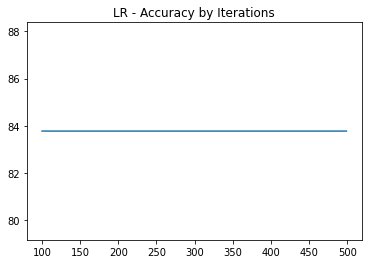

In [135]:
#Plot accuracy
plt.title('LR - Accuracy by Iterations')
plt.plot(its, acc_val, label = 'Acc Test')

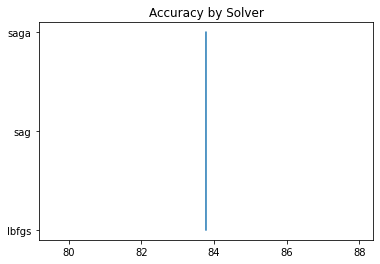

In [136]:
#plot accuracy 
plt.title('Accuracy by Solver')
plt.plot(acc_val, solv, label = 'Acc by Sol')

The above tests show that the accuracy of the logistic regression model does not change by type of solver or number of iterations, so we will take lbfgs as the solver as it is the default one for the model using the sklearn library and we will use 100 iterations. 

The Accuracy of the Logistic Regression Model is: 83.776%
The Mean Squared Error of the Logistic Regression Model is: 0.16224
Confusion Matrix for Logistc Regression:


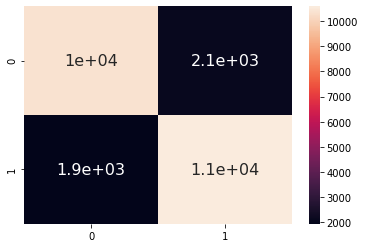

In [137]:
# Define our baseline model 
baseline_lr = LogisticRegression(max_iter=100, random_state= 0, solver='lbfgs')
baseline_lr.fit(tfidf_train_df, y_train)
pred = baseline_lr.predict(tfidf_test_df)

# Measure Performance of the model 
acc = accuracy_score(y_test, pred)*100
print(f'The Accuracy of the Logistic Regression Model is: {acc}%')
mse = mean_squared_error(y_test, pred)
print(f'The Mean Squared Error of the Logistic Regression Model is: {mse}')
cm = confusion_matrix(y_test, pred)
print('Confusion Matrix for Logistc Regression:')
sns.heatmap(cm, annot = True, annot_kws = {'size':16})
model_name.append('Baseline Logistic Regression')
model_acc.append(acc)
model_mse.append(mse)

dict = {'Actual':y_test, 'Predicted': pred}
baseline_pred = pd.DataFrame(dict)
baseline_pred.to_csv('Baseline Predictions.csv')  


The Accuracy of the Logistic Regression Model is: 83.776%
The Mean Squared Error of the Logistic Regression Model is: 0.16224
Confusion Matrix for Logistc Regression:


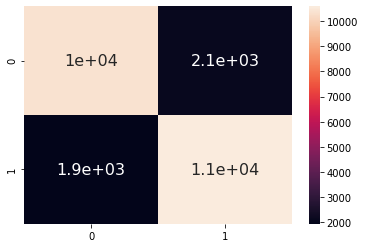

In [138]:
# Run seperate LR model for 50% train test split
#Split data for train,test
x_train = clean_data.review[:25000]
y_train = clean_data.sentiment[:25000]
x_test = clean_data.review[25000:]
y_test = clean_data.sentiment[25000:]

# Give the data a numerical representation using TF-IDF
# The numerical representation will signifiy the importance of the word in the dataset
tfidf = TfidfVectorizer(max_df=0.2, min_df = 0.02)
# Apply tfidf to train 
tfidf_train = tfidf.fit_transform(x_train)
tfidf_train_df = pd.DataFrame(tfidf_train.toarray(), columns = tfidf.get_feature_names())
tfidf_train_df.head()
# Apply tfidf to test 
tfidf_test = tfidf.transform(x_test)
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns = tfidf.get_feature_names())
tfidf_test_df.head()

# Logistic Regression
extra_test_lr = LogisticRegression(max_iter=100, random_state= 0, solver='lbfgs')
extra_test_lr.fit(tfidf_train_df, y_train)
pred = extra_test_lr.predict(tfidf_test_df)

# Measure Performance of the model 
acc = accuracy_score(y_test, pred)*100
print(f'The Accuracy of the Logistic Regression Model is: {acc}%')
mse = mean_squared_error(y_test, pred)
print(f'The Mean Squared Error of the Logistic Regression Model is: {mse}')
cm = confusion_matrix(y_test, pred)
print('Confusion Matrix for Logistc Regression:')
sns.heatmap(cm, annot = True, annot_kws = {'size':16})

model_name.append('50pc Logistic Regression')
model_acc.append(acc)
model_mse.append(mse)

### Convolutional Neural Network

In [139]:
# Read in clean data
df = pd.read_csv('clean_imdb_data.csv')

In [140]:
# Turn into tokens
def tokenize(data):
    tokens = data.split(' ')
    return tokens

In [141]:
token_reviews = df['review'].apply(tokenize)
print(token_reviews)

0        [one, reviewer, mention, watch, oz, episode, h...
1        [wonderful, little, production, filming, techn...
2        [think, wonderful, way, spend, time, hot, summ...
3        [basically, family, little, boy, jake, think, ...
4        [petter, matter, love, time, money, visually, ...
                               ...                        
49995    [think, movie, right, good, job, creative, ori...
49996    [bad, plot, bad, dialogue, bad, act, idiotic, ...
49997    [catholic, teach, parochial, elementary, schoo...
49998    [go, disagree, previous, comment, side, martin...
49999    [one, expect, star, trek, movie, high, art, fa...
Name: review, Length: 50000, dtype: object


In [142]:
# Encode reviews
tokenizer = Tokenizer()
tokenizer.fit_on_texts(token_reviews)

In [143]:
from keras.preprocessing.sequence import pad_sequences
# Sequence Encode
encoded_reviews = tokenizer.texts_to_sequences(token_reviews)
# Pad Sequences
max_length = max([len(s) for s in token_reviews])
padded_reviews = pad_sequences(encoded_reviews, maxlen = max_length, padding = 'post')
sentiment_val = df['sentiment']
print(padded_reviews)

[[    3  1011   314 ...     0     0     0]
 [  298    52   233 ...     0     0     0]
 [   20   298    33 ...     0     0     0]
 ...
 [ 2734  1175 25627 ...     0     0     0]
 [   13  2418   780 ...     0     0     0]
 [    3   168    75 ...     0     0     0]]


In [144]:
#Split data for train,test
x_train = padded_reviews[:35000]
y_train = sentiment_val[:35000]
x_test = padded_reviews[35000:]
y_test = sentiment_val[35000:]

In [145]:
# Define size of vocab 
vocabulary_size = len(tokenizer.word_index)+1

In [146]:
# Define the model 
model = Sequential()
model.add(Embedding(vocabulary_size, 100, input_length=max_length))
model.add(Conv1D(filters = 32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1394, 100)         5881400   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1387, 32)          25632     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 693, 32)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 22176)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                221770    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 6,128,813
Trainable params: 6,128,813
Non-trainable params: 0
____________________________________________

In [147]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy','mse','mae'])

In [148]:
model.fit(x_train, y_train, epochs=10, verbose = 2)

Epoch 1/10
1094/1094 - 122s - loss: 0.3356 - accuracy: 0.8437 - mse: 0.1055 - mae: 0.2123
Epoch 2/10
1094/1094 - 121s - loss: 0.1435 - accuracy: 0.9468 - mse: 0.0402 - mae: 0.0825
Epoch 3/10
1094/1094 - 121s - loss: 0.0503 - accuracy: 0.9833 - mse: 0.0129 - mae: 0.0289
Epoch 4/10
1094/1094 - 120s - loss: 0.0141 - accuracy: 0.9961 - mse: 0.0034 - mae: 0.0086
Epoch 5/10
1094/1094 - 120s - loss: 0.0087 - accuracy: 0.9974 - mse: 0.0020 - mae: 0.0048
Epoch 6/10
1094/1094 - 123s - loss: 0.0117 - accuracy: 0.9963 - mse: 0.0030 - mae: 0.0057
Epoch 7/10
1094/1094 - 119s - loss: 0.0054 - accuracy: 0.9983 - mse: 0.0013 - mae: 0.0030
Epoch 8/10
1094/1094 - 121s - loss: 0.0019 - accuracy: 0.9994 - mse: 4.7928e-04 - mae: 0.0013
Epoch 9/10
1094/1094 - 118s - loss: 0.0087 - accuracy: 0.9969 - mse: 0.0023 - mae: 0.0040
Epoch 10/10
1094/1094 - 119s - loss: 0.0077 - accuracy: 0.9972 - mse: 0.0021 - mae: 0.0039


In [149]:
loss, acc, mse, mae = model.evaluate(x_test, y_test, verbose = 0)
print('Test Accuracy: %f' %(acc*100))
print('Mean Squared Error: %f' %(mse))
print('Mean Absolute Error: %f' %(mae))

model_name.append('70% Sequential CNN')
model_acc.append(acc*100)
model_mse.append(mse)

Test Accuracy: 87.166667
Mean Squared Error: 0.116430
Mean Absolute Error: 0.129812


Change the train test split to see what happens

In [150]:
# Split the train test data 50%
x_train = padded_reviews[:25000]
y_train = sentiment_val[:25000]
x_test = padded_reviews[25000:]
y_test = sentiment_val[25000:]

In [151]:
# Run model for 50% set
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy','mse','mae'])
cnn = model.fit(x_train, y_train, epochs=10, verbose = 2)
loss, acc, mse, mae = model.evaluate(x_test, y_test, verbose = 0)
print('Test Accuracy: %f' %(acc*100))


Epoch 1/10
782/782 - 87s - loss: 0.0064 - accuracy: 0.9980 - mse: 0.0016 - mae: 0.0025
Epoch 2/10
782/782 - 86s - loss: 0.0064 - accuracy: 0.9983 - mse: 0.0014 - mae: 0.0022
Epoch 3/10
782/782 - 87s - loss: 0.0011 - accuracy: 0.9996 - mse: 3.0329e-04 - mae: 5.7945e-04
Epoch 4/10
782/782 - 87s - loss: 1.5715e-04 - accuracy: 1.0000 - mse: 4.0211e-05 - mae: 9.7980e-05
Epoch 5/10
782/782 - 85s - loss: 6.5828e-06 - accuracy: 1.0000 - mse: 6.7406e-09 - mae: 6.5749e-06
Epoch 6/10
782/782 - 86s - loss: 3.0637e-06 - accuracy: 1.0000 - mse: 1.7814e-09 - mae: 3.0582e-06
Epoch 7/10
782/782 - 87s - loss: 1.8232e-06 - accuracy: 1.0000 - mse: 6.8597e-10 - mae: 1.8183e-06
Epoch 8/10
782/782 - 86s - loss: 1.1787e-06 - accuracy: 1.0000 - mse: 3.0745e-10 - mae: 1.1741e-06
Epoch 9/10
782/782 - 86s - loss: 7.8477e-07 - accuracy: 1.0000 - mse: 1.4451e-10 - mae: 7.8024e-07
Epoch 10/10
782/782 - 87s - loss: 5.2041e-07 - accuracy: 1.0000 - mse: 6.8762e-11 - mae: 5.1597e-07
Test Accuracy: 92.383999


In [152]:
print('Test Accuracy: %f' %(acc*100))
print('Mean Squared Error: %f' %(mse))
print('Mean Absolute Error: %f' %(mae))

model_name.append('50pc Sequential')
model_acc.append(acc*100)
model_mse.append(mse)

Test Accuracy: 92.383999
Mean Squared Error: 0.071306
Mean Absolute Error: 0.076573


In [153]:
# save the eval metrics
dict = {'Model Name': model_name, 'Accuracy': model_acc, 'Mean Squared Error': model_mse}
measures_df = pd.DataFrame(dict)

In [154]:
measures_df

,Model Name,Accuracy,Mean Squared Error
0,Baseline Logistic Regression,83.776000,0.162240
1,50pc Logistic Regression,83.776000,0.162240
2,70% Sequential CNN,87.166667,0.116430
3,50pc Sequential,92.383999,0.071306


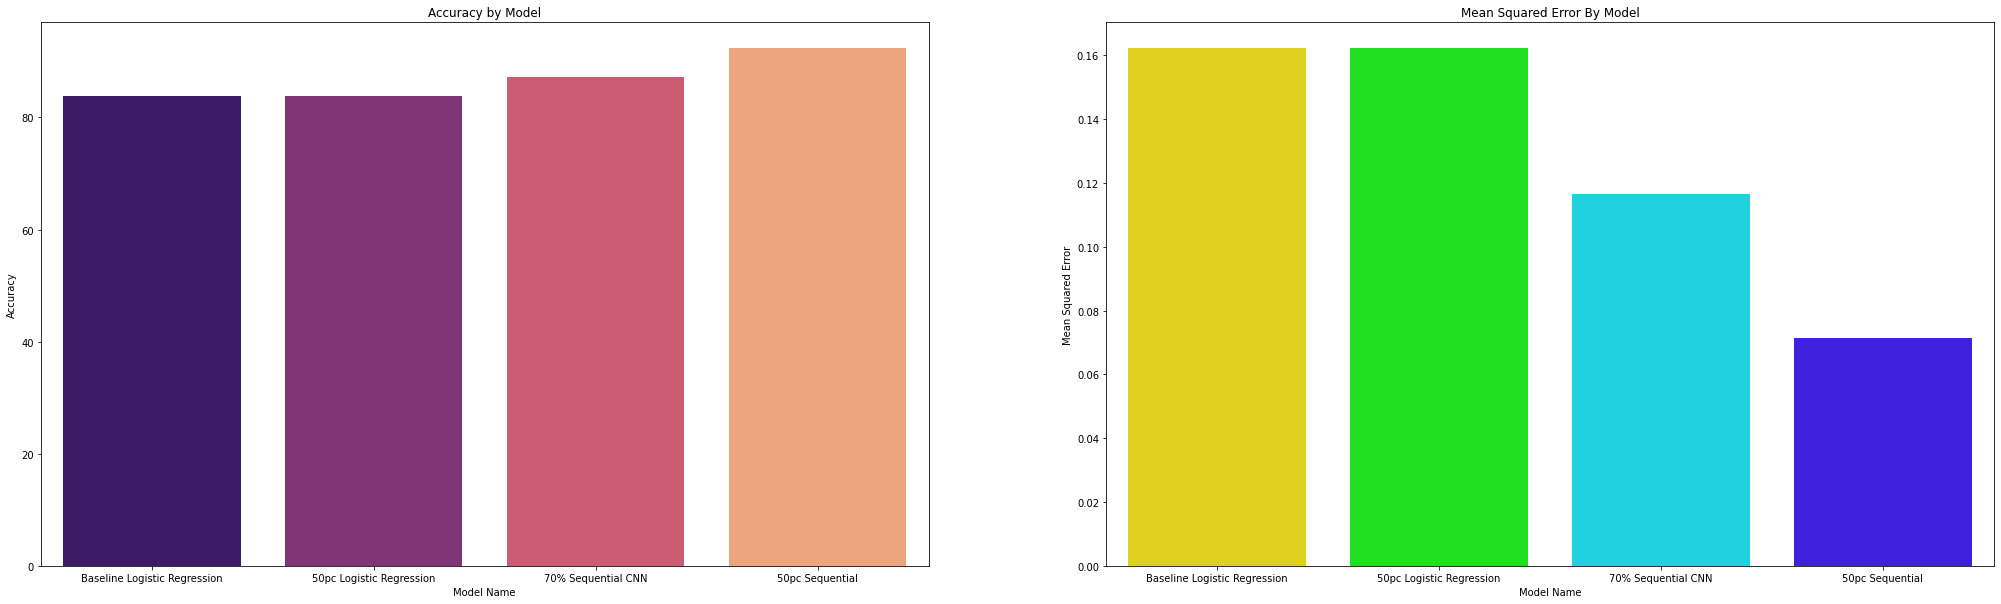

In [155]:
# Plot the evaluation metrics for all models
fig, (ax1, ax2,) = plt.subplots(1, 2,  figsize=(35,10))
ax1 = sns.barplot(x= measures_df['Model Name'], y= measures_df['Accuracy'], ax = ax1, palette = 'magma')
ax2 = sns.barplot(x= measures_df['Model Name'], y = measures_df['Mean Squared Error'], ax = ax2, palette = 'gist_rainbow')
ax1.set_title('Accuracy by Model')
ax2.set_title('Mean Squared Error By Model')
plt.show()